In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pickle

import torch
import torch.nn.functional as F

In [2]:
with uproot.open("../pythia/output/dataset_diHiggs_mu60_NumEvents10k_MinJetpT25.root:fastjet") as f:
    # jet features
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_truth_sig = f["jet_pufr_truth"].array()
    
    # trk features
    trk_pt_sig = f["trk_jet_pT"].array()
    trk_eta_sig = f["trk_jet_eta"].array()
    trk_phi_sig = f["trk_jet_phi"].array()
    trk_q_sig = f["trk_jet_q"].array()
    trk_d0_sig = f["trk_jet_d0"].array()
    trk_z0_sig = f["trk_jet_z0"].array()
    
    # event label
    label_sig = np.ones(len(jet_pt_sig))
    
with uproot.open("../pythia/output/dataset_4b_mu60_NumEvents10k_MinJetpT25.root:fastjet") as f:
    # jet features
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_truth_bkg = f["jet_pufr_truth"].array()
    
    # trk features
    trk_pt_bkg = f["trk_jet_pT"].array()
    trk_eta_bkg = f["trk_jet_eta"].array()
    trk_phi_bkg = f["trk_jet_phi"].array()
    trk_q_bkg = f["trk_jet_q"].array()
    trk_d0_bkg = f["trk_jet_d0"].array()
    trk_z0_bkg = f["trk_jet_z0"].array()
    
    # event label
    label_bkg = np.zeros(len(jet_pt_sig))


In [3]:
# Join signal and background
jet_pt = ak.concatenate([jet_pt_sig, jet_pt_bkg], axis=0)
jet_eta = ak.concatenate([jet_eta_sig, jet_eta_bkg], axis=0)
jet_phi = ak.concatenate([jet_phi_sig, jet_phi_bkg], axis=0)
jet_m = ak.concatenate([jet_m_sig, jet_m_bkg], axis=0)
jet_pufr_truth = ak.concatenate([jet_pufr_truth_sig, jet_pufr_truth_bkg], axis=0)

trk_pt = ak.concatenate([trk_pt_sig, trk_pt_bkg], axis=0)
trk_eta = ak.concatenate([trk_eta_sig, trk_eta_bkg], axis=0)
trk_phi = ak.concatenate([trk_phi_sig, trk_phi_bkg], axis=0)
trk_q = ak.concatenate([trk_q_sig, trk_q_bkg], axis=0)
trk_d0 = ak.concatenate([trk_d0_sig, trk_d0_bkg], axis=0)
trk_z0 = ak.concatenate([trk_z0_sig, trk_z0_bkg], axis=0)

labels = ak.concatenate([label_sig, label_bkg], axis=0)

In [4]:
%%time
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m,jet_pufr_truth]

jet_feat_list = [x[:,:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=2)

print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

Num Events:  20000
Num Jets in first event:  109
Num Jet Features:  5
CPU times: user 59.3 ms, sys: 8.85 ms, total: 68.2 ms
Wall time: 67.8 ms


In [5]:
%%time
trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0]
trk_feat_list = [x[:,:,:,np.newaxis] for x in trk_feat_list]
trk_feats = ak.concatenate(trk_feat_list, axis=3)

print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Num Events:  20000
Num Jets in first event:  109
Num Tracks in first event first jet:  140
Num Tracks features:  6
CPU times: user 6.07 s, sys: 2.55 s, total: 8.62 s
Wall time: 8.62 s


In [6]:
# Shuffle events
p = np.random.permutation(len(labels))
jet_feats = jet_feats[p]
trk_feats = trk_feats[p]
labels = labels[p]

In [7]:
jet_mask = abs(jet_feats[:,:,1])<4
selected_jets = jet_feats[jet_mask]
selected_tracks = trk_feats[jet_mask]

trk_q_cut = selected_tracks[:,:,:,3]!=0            # Skip neutral particles
trk_eta_cut = abs(selected_tracks[:,:,:,1])<4.5    # Skip forward region
trk_pt_cut = selected_tracks[:,:,:,0]>0.4          # 400MeV Cut

mask = trk_q_cut & trk_eta_cut & trk_pt_cut

selected_tracks = selected_tracks[mask]

In [8]:
# Skip trackless jets!
trackless_jets_mask = (ak.num(selected_tracks, axis=2)!=0)
selected_jets = selected_jets[trackless_jets_mask]
selected_tracks = selected_tracks[trackless_jets_mask]

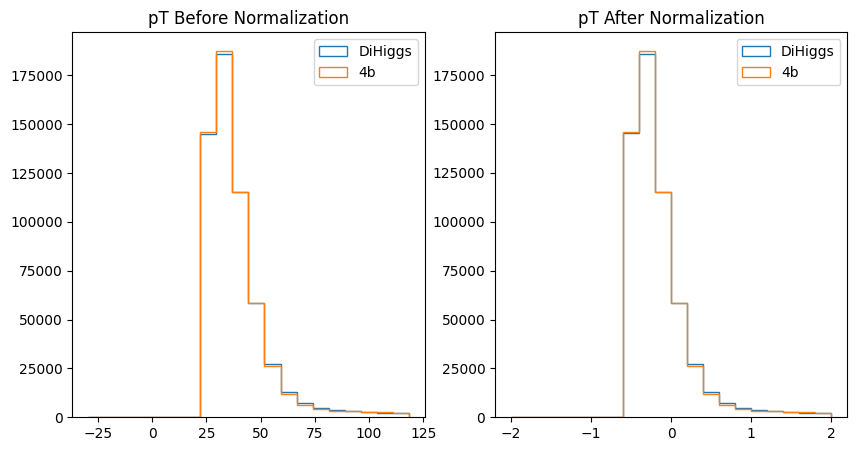

Mean Before:  44.44483004536343 
Mean After:  -9.117432292875952e-05
STD Before:  36.90699674233875 
STD After:  0.9995125784359854


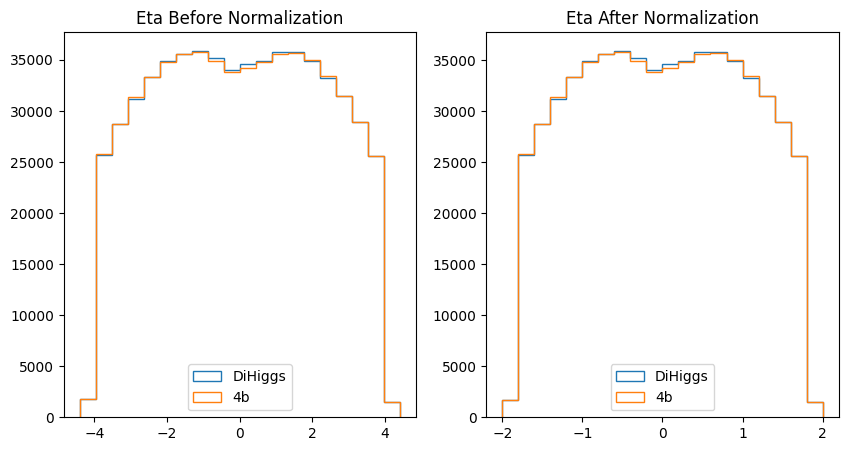

Mean Before:  0.001979616537213841 
Mean After:  -1.0491262485711773e-09
STD Before:  2.205529855272004 
STD After:  1.0002497342696075


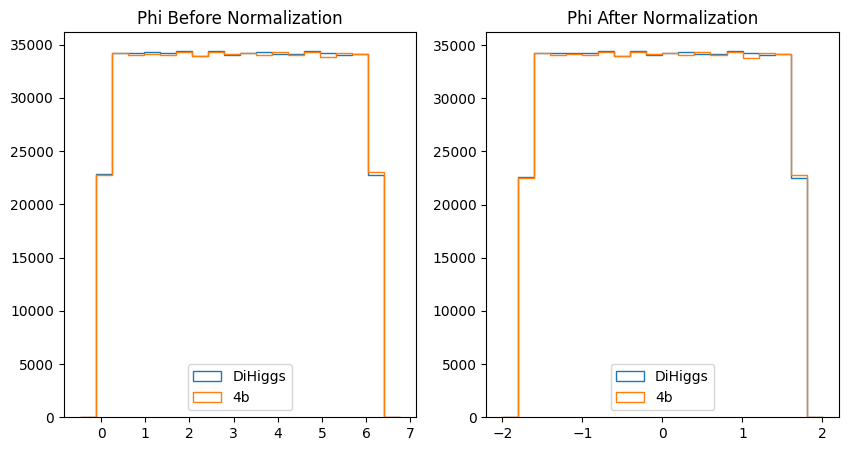

Mean Before:  3.1405133452895875 
Mean After:  4.963960070209323e-05
STD Before:  1.8123777227798505 
STD After:  1.0008568596152856


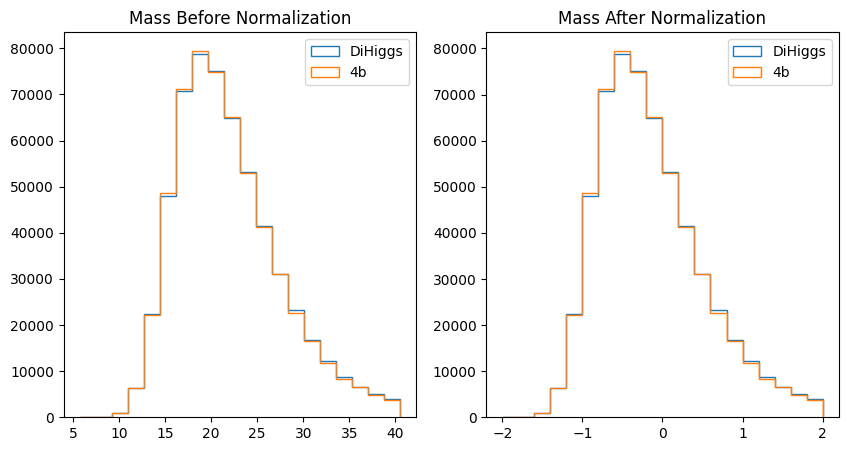

Mean Before:  23.104864226184198 
Mean After:  -2.106723064850701e-05
STD Before:  8.698599126673434 
STD After:  1.0000710805163515


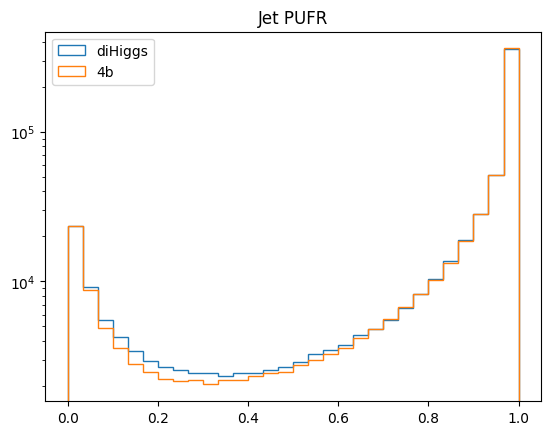

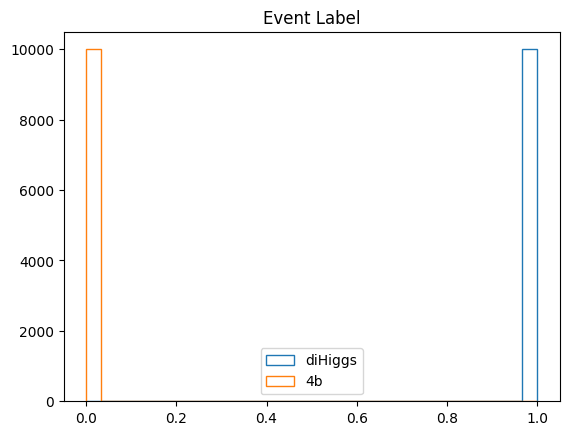

In [9]:
num_jet_feats = len(selected_jets[0][0])-1

sig = labels==1
bkg = ~sig

var_list = ['pT','Eta','Phi','Mass']

# Normalize and Plot Jet Features
norm_list = []
for i in range(num_jet_feats):
    feat = selected_jets[:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat)-2*ak.std(feat)
    maxi=ak.mean(feat)+2*ak.std(feat)
    ax1.hist(ak.ravel(feat[sig]),label='DiHiggs',histtype='step',bins=20,range=(mini,maxi))
    ax1.hist(ak.ravel(feat[bkg]),label='4b',histtype='step',bins=20,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    mini=ak.mean(norm)-2*ak.std(norm)
    maxi=ak.mean(norm)+2*ak.std(norm)
    ax2.hist(ak.ravel(norm[sig]),label='DiHiggs',histtype='step',bins=20,range=(mini,maxi))
    ax2.hist(ak.ravel(norm[bkg]),label='4b',histtype='step',bins=20,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\nMean After: ", ak.mean(norm))
    print("STD Before: ", std, "\nSTD After: ", ak.std(norm))

plt.title("Jet PUFR")
plt.hist(ak.ravel(selected_jets[:,:,-1][sig]),histtype='step',label='diHiggs',bins=30,range=(0,1))
plt.hist(ak.ravel(selected_jets[:,:,-1][bkg]),histtype='step',label='4b',bins=30,range=(0,1))
plt.yscale('log')
plt.legend()
plt.show()

plt.title("Event Label")
plt.hist(labels[sig],histtype='step',bins=30,label='diHiggs',range=(0,1))
plt.hist(labels[bkg],histtype='step',bins=30,label='4b',range=(0,1))
plt.legend()
plt.show()
    
# Append Labels
norm_list.append(selected_jets[:,:,-1])

Norm_list = [x[:,:,np.newaxis] for x in norm_list]
selected_jets = ak.concatenate(Norm_list, axis=2)

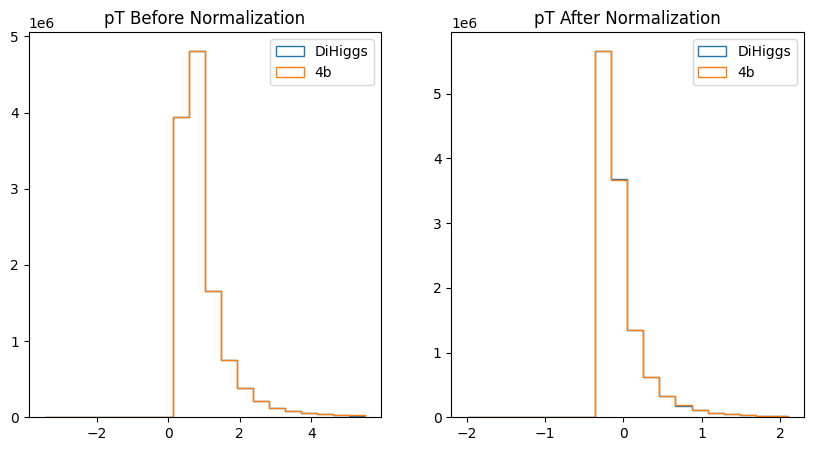

Mean Before:  1.017462596865902 
Mean After:  0.05195811420971448
STD Before:  2.2412270954199394 
STD After:  1.0228348034993424


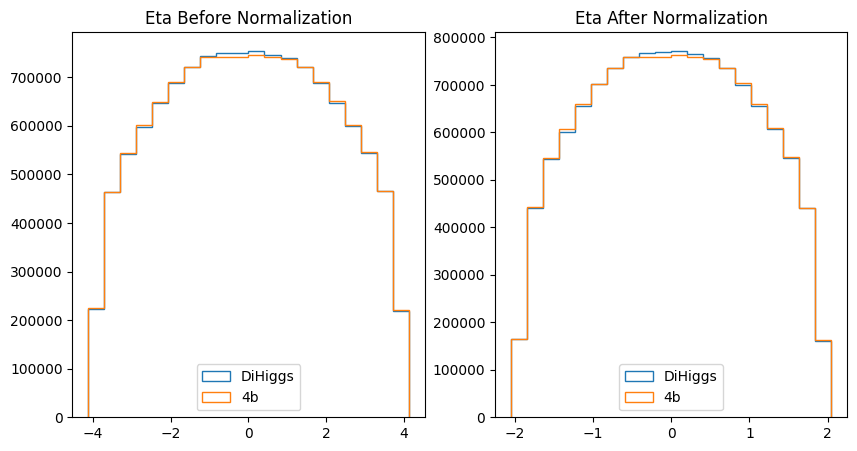

Mean Before:  0.0013370669508400977 
Mean After:  4.103121159593127e-09
STD Before:  2.0614182983893894 
STD After:  1.023434874958761


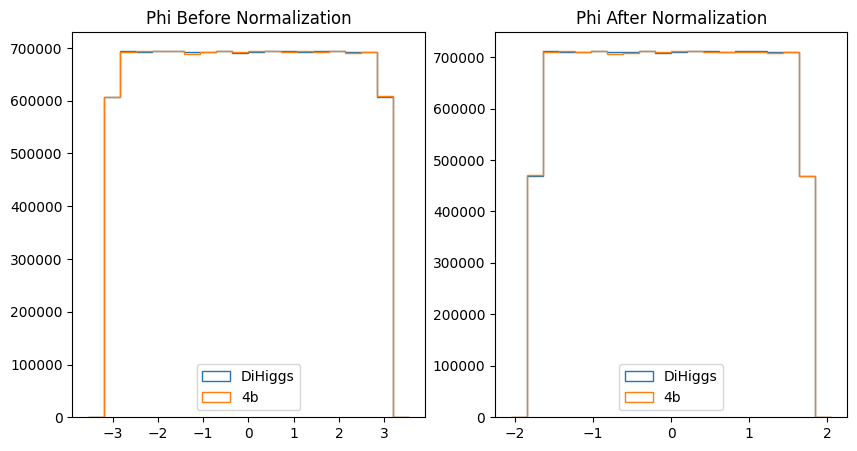

Mean Before:  -0.00011325129865242896 
Mean After:  2.269813331202252e-08
STD Before:  1.7693800079884534 
STD After:  1.0249388125638967


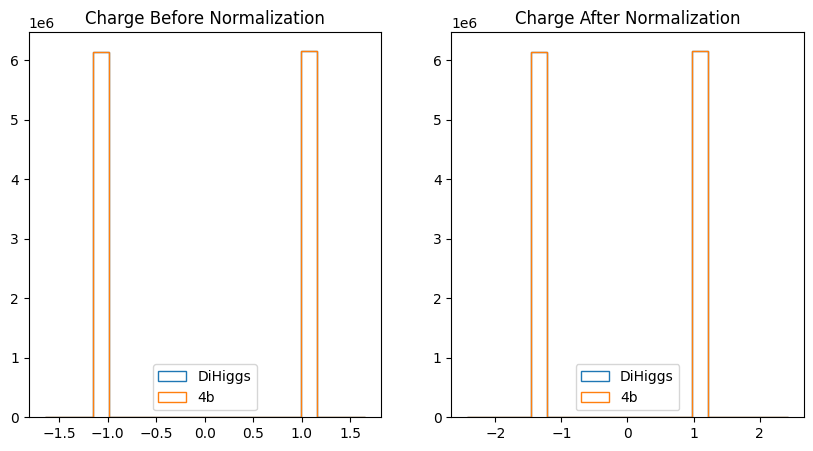

Mean Before:  0.0012919516587914957 
Mean After:  -5.261919019681682e-14
STD Before:  0.8256246401817247 
STD After:  1.2112031505841798


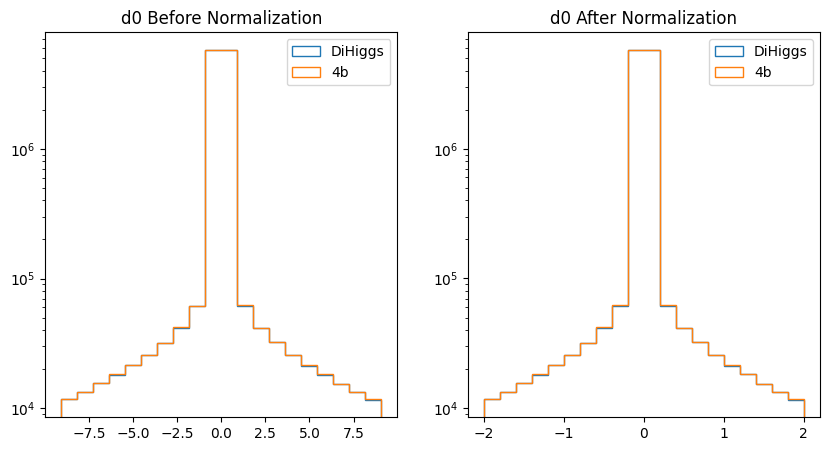

Mean Before:  -4.549800455516071e-06 
Mean After:  1.4926052236878667e-08
STD Before:  4.5385273403045865 
STD After:  1.0017032445296907


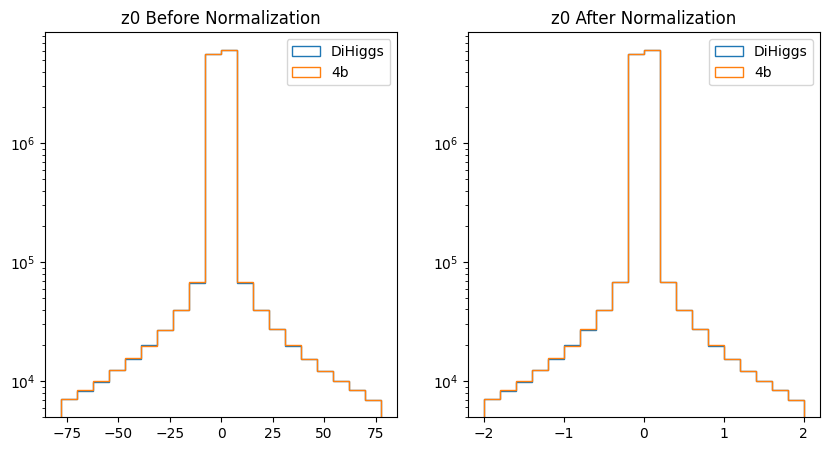

Mean Before:  -0.004298509784772506 
Mean After:  2.68997086910394e-09
STD Before:  38.91498410805562 
STD After:  1.0014343902633671


In [10]:
num_trk_feats = len(selected_tracks[0][0][0])

sig = labels==1
bkg = ~sig

var_list = ['pT','Eta','Phi','Charge', 'd0', 'z0']

norm_list = []
for i in range(num_trk_feats):
    feat = selected_tracks[:,:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat)-2*ak.std(feat)
    maxi=ak.mean(feat)+2*ak.std(feat)
    ax1.hist(ak.ravel(feat[sig]),label='DiHiggs',histtype='step',bins=20,range=(mini,maxi))
    ax1.hist(ak.ravel(feat[bkg]),label='4b',histtype='step',bins=20,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    if '0' in var_list[i]:
        ax1.set_yscale('log')
    mini=ak.mean(norm)-2*ak.std(norm)
    maxi=ak.mean(norm)+2*ak.std(norm)
    ax2.hist(ak.ravel(norm[sig]),label='DiHiggs',histtype='step',bins=20,range=(mini,maxi))
    ax2.hist(ak.ravel(norm[bkg]),label='4b',histtype='step',bins=20,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    if '0' in var_list[i]:
        ax2.set_yscale('log')
    plt.show()
    print("Mean Before: ", mean, "\nMean After: ", ak.mean(norm))
    print("STD Before: ", std, "\nSTD After: ", ak.std(norm))
    
Norm_list = [x[:,:,:,np.newaxis] for x in norm_list]
selected_tracks = ak.concatenate(Norm_list, axis=3)

In [11]:
all_tracks = ak.flatten(selected_tracks, axis=2)

print("Jet Shape:\t", selected_jets.type)
print("Trk_Jet  Shape:\t", selected_tracks.type)
print("Trk_All Shape:\t", all_tracks.type)

Jet Shape:	 20000 * var * 5 * float64
Trk_Jet  Shape:	 20000 * var * var * 6 * float64
Trk_All Shape:	 20000 * var * 6 * float64


In [12]:
#%%time
# Generate List of torch tensors on event by event basis
# Pad number of tracks per jet 

num_events = len(selected_jets)

Event_Data = []
Event_Labels = []

for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    jets = torch.Tensor(selected_jets[event,:,:])
    
    num_trks = ak.num(selected_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)

    trk_list = []
    num_jets = len(selected_jets[event])
    for jet in range(num_jets):
        tracks = torch.Tensor(selected_tracks[event][jet,:])        
        pad = (0,0,0,max_num_trks-len(tracks))        
        tracks = F.pad(tracks,pad)
        trk_list.append(torch.unsqueeze(tracks,dim=0))
    tracks = torch.cat(trk_list,dim=0)
    
    # Append all data 
    flat_tracks = torch.Tensor(all_tracks[event])
    Event_Data.append((jets,tracks,flat_tracks))
    Event_Labels.append(labels[event])

print("Processing: ", num_events, " / ", num_events)

Processing:  20000  /  20000


In [13]:
train_split = int(0.7*num_events)  # 70% train
test_split = int(0.75*num_events)  #  5% val + 25% test

Event_List = list(zip(Event_Data, Event_Labels))

Events_training = Event_List[0:train_split]
Events_validation = Event_List[train_split:test_split]
Events_testing = Event_List[test_split:]

print("Processing: ", num_events, " / ", num_events)
print("Training Events: ", len(Events_training))
print("Validation Events: ", len(Events_validation))
print("Testing Events: ", len(Events_testing))

Processing:  20000  /  20000
Training Events:  14000
Validation Events:  1000
Testing Events:  5000


In [14]:
#raise Exception("Stop!")

In [15]:
X_train, y_train = list(zip(*Events_training))
X_val, y_val = list(zip(*Events_validation))
X_test, y_test = list(zip(*Events_testing))

data = (X_train, y_train, X_val, y_val, X_test, y_test)

pickle.dump(data, open("data_combined.pkl", "wb"))

In [16]:
print("X_train Indices Reference:")
print("\tNum Events: ", len(X_train))
print("\tNum Tensors: ", len(X_train[0]), "(Jet, trk-jet, flat trk)")
print("\tNum Jets: ", len(X_train[0][0]))
print("\tNum Trks per Jet: ", len(X_train[0][1][0]))
print("\tNum Flat Trks: ", len(X_train[0][2]))
print("\tNum Jet Feats: ", len(X_train[0][0][0]))
print("\tNum Trk Feats: ", len(X_train[0][1][0][0]))
print()
print("y_train Indices Reference:")
print("\tNum Events: ", len(y_train))

X_train Indices Reference:
	Num Events:  14000
	Num Tensors:  3 (Jet, trk-jet, flat trk)
	Num Jets:  78
	Num Trks per Jet:  49
	Num Flat Trks:  1872
	Num Jet Feats:  5
	Num Trk Feats:  6

y_train Indices Reference:
	Num Events:  14000
